In [7]:
from __future__ import print_function
import csv
import matplotlib.pyplot as plt
import scipy.signal as signal

import numpy as np

In [8]:
channel_num = 7
channel_list = [2,4,6]
method = 'SSD'  #results/yolo, results_new/faster-rcnn2, results_new/mask-rcnn
dataset = 'Pathway1_1'
start_frame = 310
image_num = 548
#folder = "20190725_bbox_data"  # 2-1 250-394
#folder = '20190805_bbox_path2_2' #2-2  100-282
folder = 'results' #1-1  310-548
filename = folder+"/"+method+"_"+dataset+".txt"


bbox_count = [[0 for x in range(image_num)] for y in range(channel_num)]
ppl_count = [[0 for x in range(image_num)] for y in range(channel_num)]
confidence_mat = [[0 for x in range(image_num)] for y in range(channel_num)]
area_mat = [[0 for x in range(image_num)] for y in range(channel_num)]

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
hatch_style = ['/',  '.', 'o', 'x', '|',  '+' ,   '-' ]
               
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

In [10]:

with open(filename, 'r') as csvfile:
    
# 讀取 CSV 檔案內容
    rows = csv.reader(csvfile)
# 以迴圈輸出每一列
    for row in rows:        
        channel_idx = int(row[0])        
        img = int(row[1])
        bbox_count[channel_idx][img] = bbox_count[channel_idx][img]+1


        type = row[7].strip()
        if(img == 125):
            print(row)
        if(type == 'person'):

            ppl_count[channel_idx][img]+=1
            confidence = row[6]
            confidence_mat[channel_idx][img] = float(confidence)

            startX = int(float(row[2]))
            startY = int(float(row[3]))
            endX = int(float(row[4]))
            endY = int(float(row[5]))
            area = (endX - startX) * (endY - startY)
            area_mat[channel_idx][img] = area


csvfile.close()

['2', '125', '346', '163', '463', '463', '0.9997501', 'person']


IndexError: list index out of range

In [4]:
for i in range(image_num):
    print(str(i)+",", end = '')
    for j in range(channel_num):
        print(str(confidence_mat[j][i])+",", end = '')
    print()
    
x=range(start_frame,image_num)

0,0,0,0,0,0,0,0,
1,0,0,0,0,0,0,0,
2,0,0,0,0,0,0,0,
3,0,0,0,0,0,0,0,
4,0,0,0,0,0,0,0,
5,0,0,0,0,0,0,0,
6,0,0,0,0,0,0,0,
7,0,0,0,0,0,0,0,
8,0,0,0,0,0,0,0,
9,0,0,0,0,0,0,0,
10,0,0,0,0,0,0,0,
11,0,0,0,0,0,0,0,
12,0,0,0,0,0,0,0,
13,0,0,0,0,0,0,0,
14,0,0,0,0,0,0,0,
15,0,0,0,0,0,0,0,
16,0,0,0,0,0,0,0,
17,0,0,0,0,0,0,0,
18,0,0,0,0,0,0,0,
19,0,0,0,0,0,0,0,
20,0,0,0,0,0,0,0,
21,0,0,0,0,0,0,0,
22,0,0,0,0,0,0,0,
23,0,0,0,0,0,0,0,
24,0,0,0,0,0,0,0,
25,0,0,0,0,0,0,0,
26,0,0,0,0,0,0,0,
27,0,0,0,0,0,0,0,
28,0,0,0,0,0,0,0,
29,0,0,0,0,0,0,0,
30,0,0,0,0,0,0,0,
31,0,0,0,0,0,0,0,
32,0,0,0,0,0,0,0,
33,0,0,0,0,0,0,0,
34,0,0,0,0,0,0,0,
35,0,0,0,0,0,0,0,
36,0,0,0,0,0,0,0,
37,0,0,0,0,0,0,0,
38,0,0,0,0,0,0,0,
39,0,0,0,0,0,0,0,
40,0,0,0,0,0,0,0,
41,0,0,0,0,0,0,0,
42,0,0,0,0,0,0,0,
43,0,0,0,0,0,0,0,
44,0,0,0,0,0,0,0,
45,0,0,0,0,0,0,0,
46,0,0,0,0,0,0,0,
47,0,0,0,0,0,0,0,
48,0,0,0,0,0,0,0,
49,0,0,0,0,0,0,0,
50,0,0,0,0,0,0,0,
51,0,0,0,0,0,0,0,
52,0,0,0,0,0,0,0,
53,0,0,0,0,0,0,0,
54,0,0,0,0,0,0,0,
55,0,0,0,0,0,0,0,
56

### 大於0.9且連續十個點才連線 (Method1)

In [110]:
def cont_range(confident_mat):
    
    start=0
    end=0
    tag=False
    my_list=[]
    for idx,conf in enumerate(confident_mat):
        #print(idx)
        if tag==False and conf>0.9:
            start=idx
            end=idx
            tag=True
            #print("[1]"+str(start)+","+str(end))
        elif tag==True and conf>0.9:
            end=idx
            #print("[2]"+str(start)+","+str(end))
        
        if tag==True and (conf<0.9 or idx==np.size(confident_mat)-1):
            tag=False
            #print("[3]"+str(start)+","+str(end))
            if end-start>10:
                my_list.append((start,end))
            
    return my_list

confident_mat=[0.5,0.6,0.7,0.8,0.9,0.95,0.96,0.97,0.98,0.96,0.98,0.95,0.92,0.89,0.88,0.8,0.6,0.7,0.8,0.88,0.92,0.95,0.99,0.95]
#print(np.size(confident_mat))   
range_list = cont_range(confidence_mat[0])
print(range_list)

[(110, 208), (426, 531)]


[(105, 185), (470, 545)]
[(104, 208), (425, 544)]
[(104, 224), (421, 544)]


Text(0.5,1,'mask-rcnn')

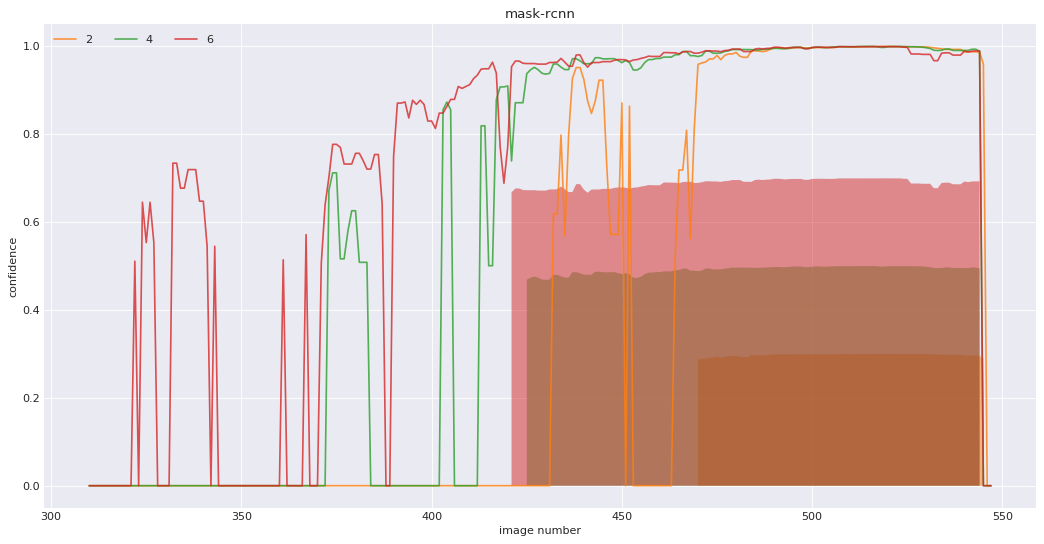

In [111]:
plt.style.use('seaborn-darkgrid')
####-----------confidence---------------

#plt.subplot(3,1,1)
plt.figure(figsize=(16,8), dpi= 80)
for i in channel_list:
    y = confidence_mat[i][start_frame:]
    y1= signal.medfilt(y,3)    
    global_y=y1
    plt.plot(x,y1,alpha=0.8,label=i,color=tableau20[i])
    range_list = cont_range(signal.medfilt(confidence_mat[i]))
    print(range_list)
    for r in range_list:
        if(r[0]>=start_frame and r[1]<image_num):
            X = range(r[0],r[1]+1)
            Y = y1[r[0]-start_frame:r[1]+1-start_frame]*0.1*(i+1)
            plt.fill_between(X,Y, facecolor=tableau20[i],alpha=0.5) #,hatch=hatch_style[i]
    
plt.legend(loc='upper left', ncol=3)
plt.xlabel('image number')
plt.ylabel('confidence')
plt.title(method)

Text(0.5,0.98,'mask-rcnn')

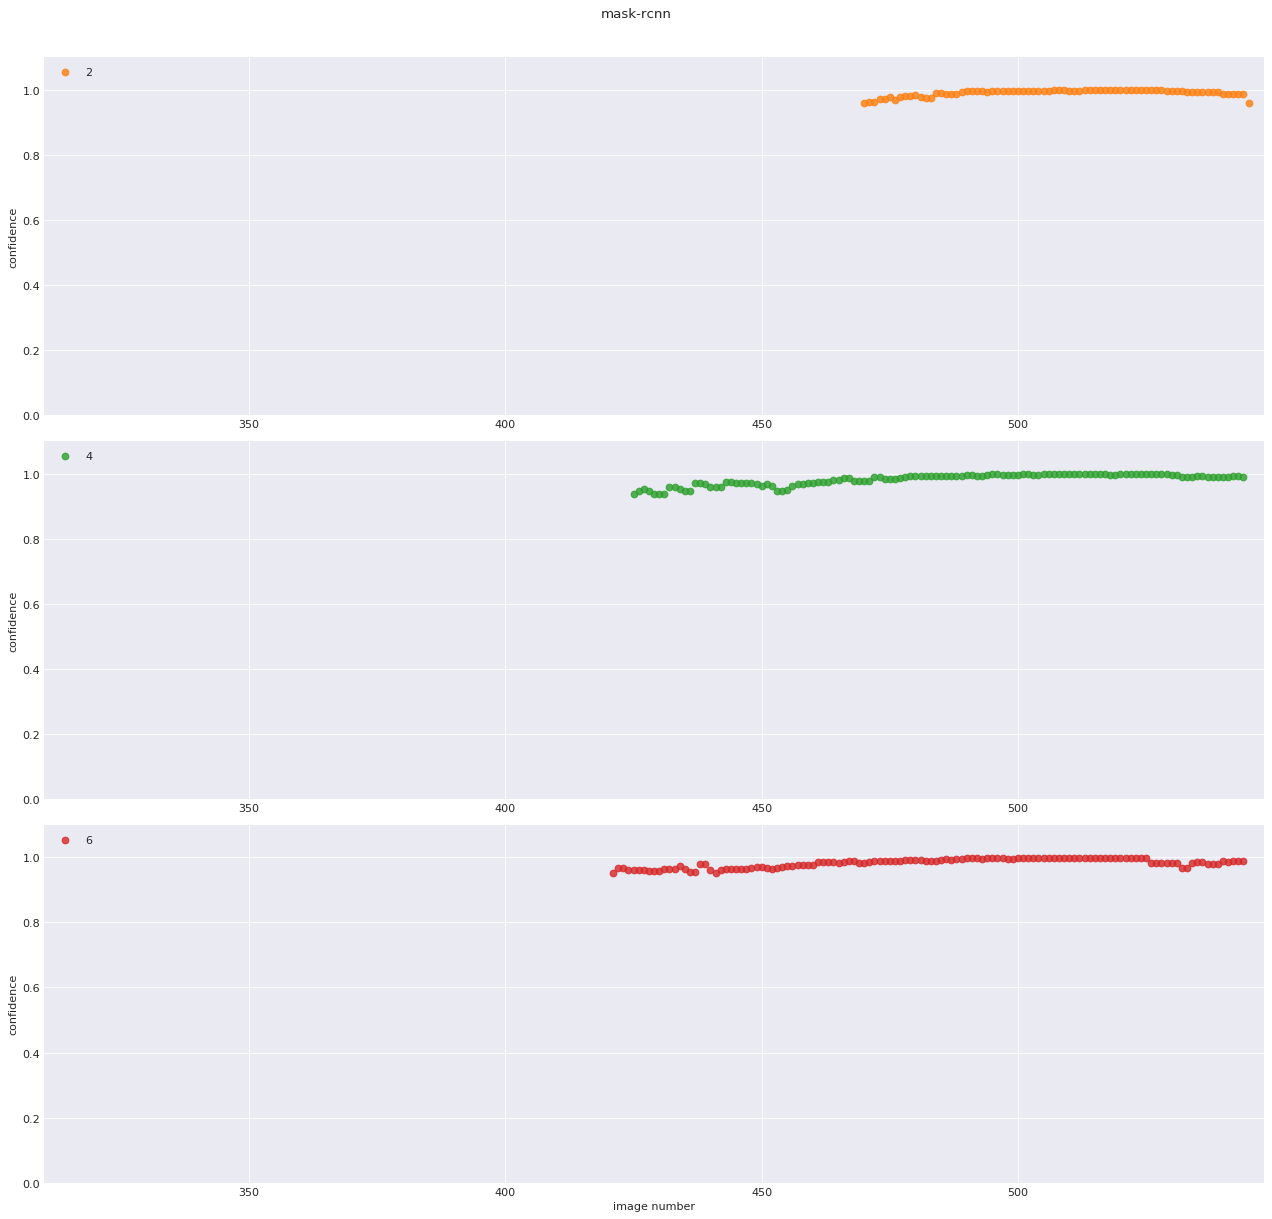

In [112]:
plt.style.use('seaborn-darkgrid')
####-----------confidence---------------

fig_num=1
fig = plt.figure(figsize=(16,16), dpi= 80)

for i in channel_list:
    y = confidence_mat[i][start_frame:]
    y1= signal.medfilt(y,3)     
    range_list =cont_range(y1)
    
      
    line_count = 0
    for r in range_list:
    
    #global_y=y1
    #X = range(r[0]+start_frame,r[1]+start_frame+1)
        Y=np.zeros(image_num-start_frame)
        
        Y=y1[r[0]:r[1]+1]
        X=x[r[0]:r[1]+1]
        plt.subplot(np.size(channel_list),1,fig_num)
        plt.scatter(X,Y,alpha=0.8,label=i,color=tableau20[i+line_count])
        line_count=line_count+1
        
    fig_num=fig_num+1
    plt.legend(loc='upper left', ncol=3)
    plt.ylabel('confidence')
    plt.ylim(0,1.1) 
    plt.xlim(start_frame, image_num)  
plt.xlabel('image number')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle(method, fontsize=12)
    

Text(0.5,0.98,'mask-rcnn')

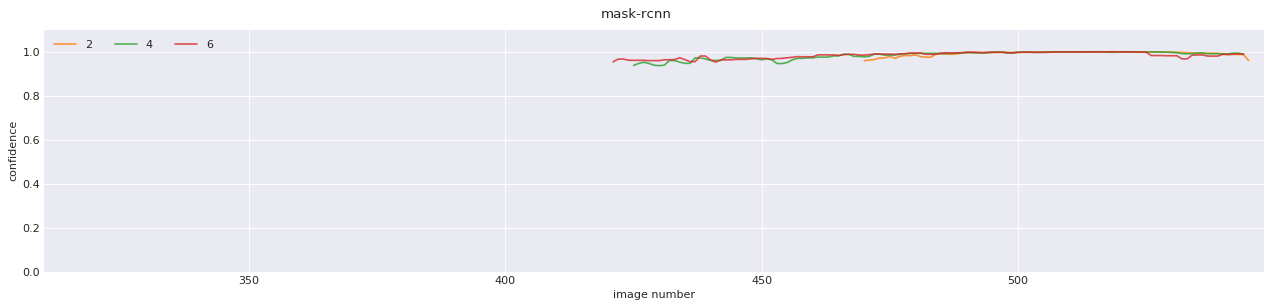

In [113]:
plt.style.use('seaborn-darkgrid')
####-----------confidence---------------

fig_num=1
fig = plt.figure(figsize=(16,4), dpi= 80)

for i in channel_list:
    y = confidence_mat[i][start_frame:]
    y1= signal.medfilt(y,3)     
    range_list =cont_range(y1)
    
      
    line_count = 0
    for r in range_list:
        X = range(r[0]+start_frame,r[1]+start_frame+1)
        Y=np.zeros(image_num-start_frame)
        Y[r[0]:r[1]+1]=y1[r[0]:r[1]+1]
    #plt.subplot(4,1,fig_num)
        plt.plot(X,y1[r[0]:r[1]+1],alpha=0.8,label=i,color=tableau20[i+line_count])
        line_count=line_count+1
        
    fig_num=fig_num+1
    plt.legend(loc='upper left', ncol=3)
    plt.ylabel('confidence')
    plt.ylim(0,1.1) 
    plt.xlim(start_frame, image_num)  
plt.xlabel('image number')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle(method, fontsize=12)
    

### 由近而遠掃描，零超過兩點停止，連續十點才連線 (Method2)

In [24]:
def plot_count(confidence_mat):
    
    start=0
    end=0
    tag=False
    zero_count_tag=False    
    zero_count=0;
    my_list=[]
    for idx,conf in reversed(list(enumerate(confidence_mat))):
        #print(str(tag)+" "+str(zero_count_tag)+" "+str(start)+" "+str(end)+" "+str(conf))
        if tag==False and conf>0:
            start=idx
            end=idx
            tag=True
            zero_count_tag=False
            #print("[1]"+str(start)+","+str(end))
        elif tag==True and zero_count_tag==True and conf==0:
            start=idx
            tag=False
            zero_count_tag=False
            if end-start>10:
                my_list.append((start,end))
                      
        elif tag==True and zero_count_tag==False and conf==0:
            zero_count_tag=True
            zero_count=zero_count+1
            #print("[2]"+str(start)+","+str(end))
        
        elif tag==True and conf!=0:
            zero_count_tag=False
            start=idx                      
            
    return my_list

confident_mat=[1,1,0,0,0,0,0,0,1,1,1,1,0,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,0,0,0,0]
print(plot_count(confident_mat))   
range_list = plot_count(confidence_mat[2])
print(range_list)

[(12, 35)]
[(461, 545), (430, 453), (202, 219), (103, 194)]


### filter drop

In [25]:



def filter_drop(confidence_mat,range_list,th):
    drop_list =[]
    for r in range_list:
        
        #print("##"+str(r[0]+start_frame)+" "+str(r[1]+start_frame) )        
        prev_conf = 0
        
        for idx,conf in enumerate(confidence_mat[r[0]:r[1]+1]):
            current_conf = conf
            diff = current_conf-prev_conf     
            drop_ratio = diff/prev_conf
            
            if drop_ratio< -th:
                #print(r[0]+idx+start_frame)
                
                #print(diff)
                print(drop_ratio)
                drop_list.append((r[0]+idx+start_frame,current_conf))
            prev_conf=conf
    return drop_list    


## 標出drop >10%的點

-0.12775112083072815
-0.1652934345609593
-0.14964320432029493
-0.20207953435332301
-0.30453644431973365
-0.286173463779819
-0.20617997167357796
-0.21940288133373625
-1.0
-0.38873392577461574
-0.18769941873832247
-0.274909441987307
-0.18758640278051178
-0.1780028462311913
-0.10833598220064836
-0.1494631399642651
-0.158591380873021
-1.0


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


Text(0.5,0.98,'mask-rcnn')

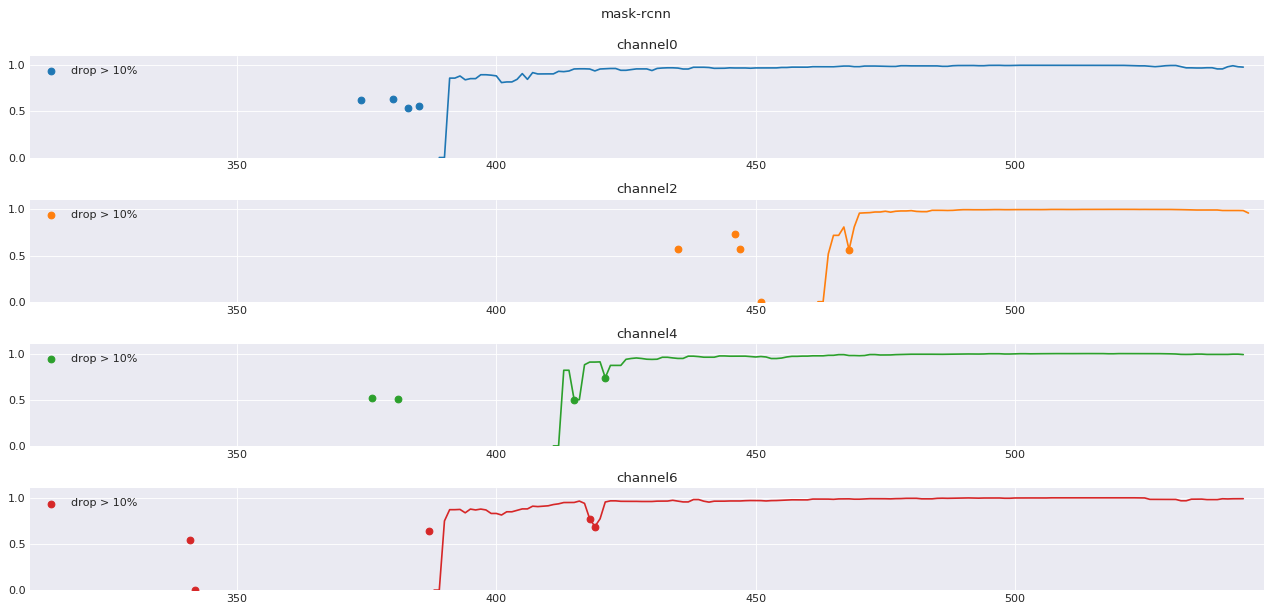

In [26]:
fig = plt.figure(figsize=(16,8), dpi= 80)                
for idx,ch in enumerate(channel_list):            
       
    y = confidence_mat[ch][start_frame:]           
    y1= signal.medfilt(y,3)      
    range_list =plot_count(y1)   # (1) cout_range   (2) plot_count
    #print(ch)
    drop_list = filter_drop(y1,range_list,0.1)    

    x=range(range_list[0][0]+start_frame,range_list[0][1]+1+start_frame)
    Y=y1[range_list[0][0]:range_list[0][1]+1]
    plt.subplot(np.size(channel_list),1,idx+1)
    plt.plot(x,Y,color=tableau20[ch])
    #print(drop_list)
    #print(zip(*drop_list))
    if drop_list:
        plt.scatter(*zip(*drop_list),color=tableau20[ch],label="drop > 10%")
    plt.title("channel"+str(ch))
    plt.legend(loc='upper left')    
    plt.ylim(0,1.1)
    plt.xlim(start_frame,image_num)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle(method, fontsize=12)

## 直接保留90%以上的點 (method1+filter drop)

[]
[]
[]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


Text(0.5,0.98,'mask-rcnn')

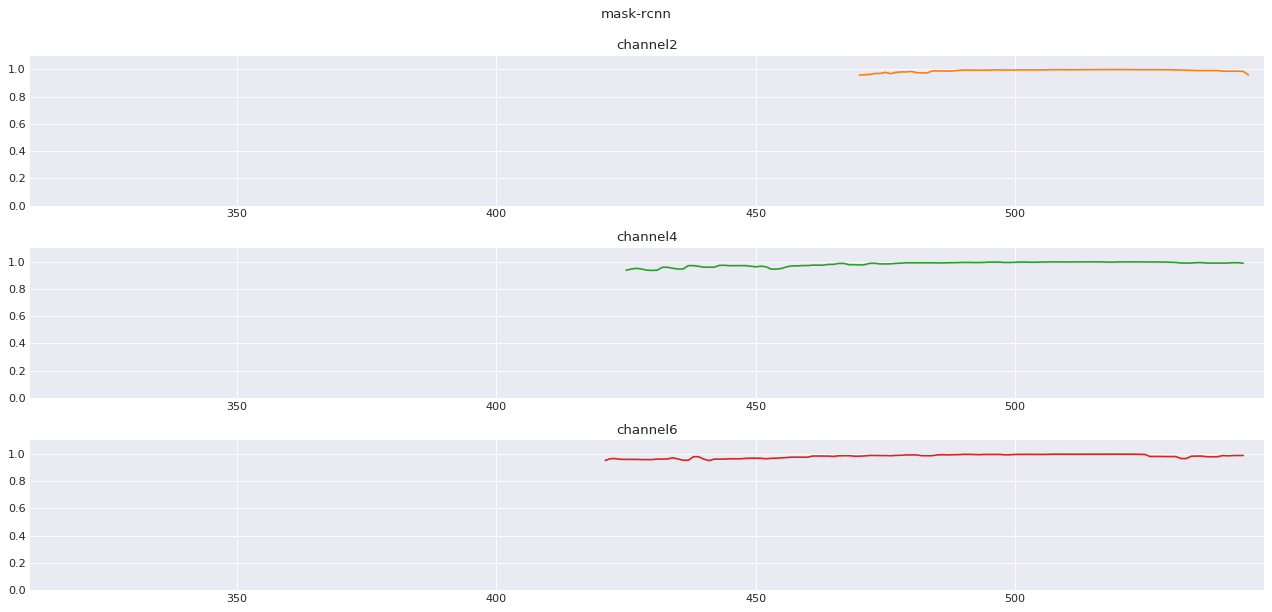

In [43]:
fig = plt.figure(figsize=(16,8), dpi= 80)          
for idx,ch in enumerate(channel_list):            
         
    y = confidence_mat[ch][start_frame:]           
    y1= signal.medfilt(y,3)      
    range_list =cont_range(y1)   # (1) cont_range   (2) plot_count
    #print(ch)
    drop_list = filter_drop(y1,range_list,0.1)    

    x=range(range_list[0][0]+start_frame,range_list[0][1]+1+start_frame)
    Y=y1[range_list[0][0]:range_list[0][1]+1]
    plt.subplot(np.size(channel_list),1,idx+1)
    plt.plot(x,Y,color=tableau20[ch])
    print(drop_list)
    plt.title("channel"+str(ch))
    
    plt.ylim(0,1.1)
    plt.xlim(start_frame,image_num)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle(method, fontsize=12)

## 與tracking比較

In [96]:
track_fasterrcnn2_Pathway1_1 = [0 for y in range(channel_num)]
track_fasterrcnn2_Pathway1_1[6] = [[106,250],[374,527],[536,545]]
track_fasterrcnn2_Pathway1_1[2] = [[107,188],[464,545]]
track_fasterrcnn2_Pathway1_1[4] = [[106,232],[421,547]]


In [119]:
track_maskrcnn_Pathway1_1 = [0 for y in range(channel_num)]
track_maskrcnn_Pathway1_1[6] = [[105,267],[324,342],[367,547]]
track_maskrcnn_Pathway1_1[4] = [[105,240],[369,378],[409,544]]
track_maskrcnn_Pathway1_1[2] = [[106,196],[205,214],[433,451],[464,545]]

106
196
205
214
433
451
464
545
[]
105
240
369
378
409
544
[]
105
267
324
342
367
547
[]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


Text(0.5,0.98,'compare with track:mask-rcnn')

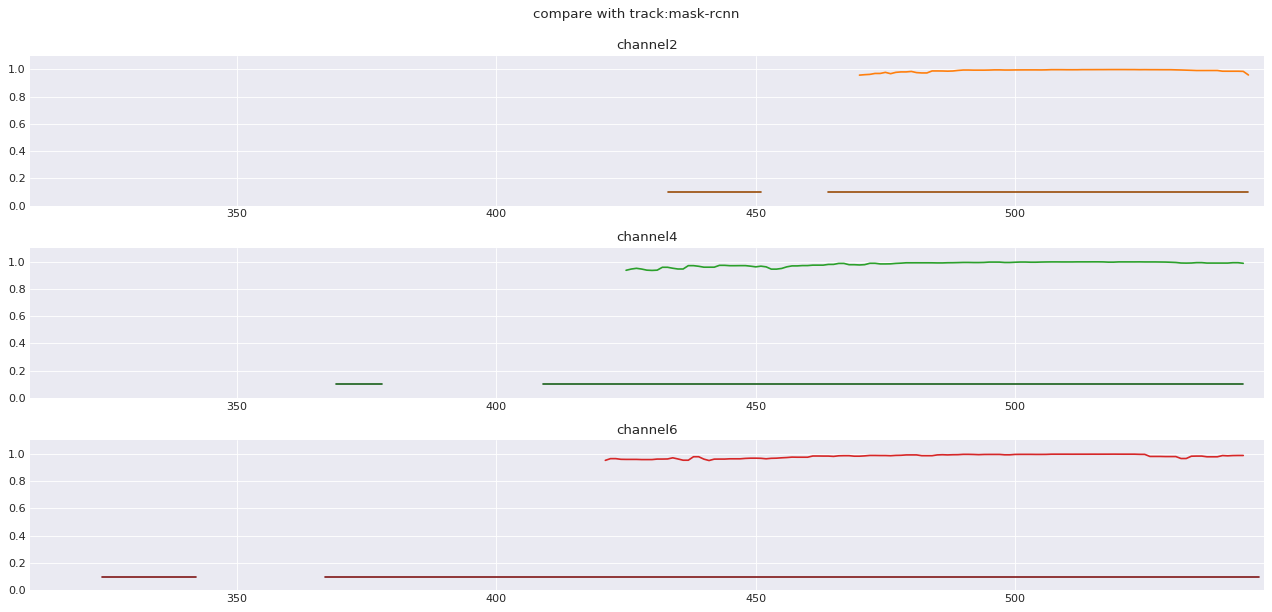

In [120]:
fig = plt.figure(figsize=(16,8), dpi= 80)          
for idx,ch in enumerate(channel_list):            
         
    y = confidence_mat[ch][start_frame:]           
    y1= signal.medfilt(y,3)      
    range_list =cont_range(y1)   # (1) cont_range   (2) plot_count
    #print(ch)
    drop_list = filter_drop(y1,range_list,0.1)    

    x=range(range_list[0][0]+start_frame,range_list[0][1]+1+start_frame)
    Y=y1[range_list[0][0]:range_list[0][1]+1]
    plt.subplot(np.size(channel_list),1,idx+1)
    plt.plot(x,Y,color=tableau20[ch])
    
    #plot track 
    for track in track_maskrcnn_Pathway1_1[ch]:
        start = track[0]
        end = track[1]
        print(start)
        print(end)
        if end>=start_frame:
            track_frame_num = (end-start+1)
            r, g, b = tableau20[ch]
            light_color = (r *0.6, g *0.6, b *0.6)
            plt.plot(range(start,end+1),[0.1]*track_frame_num,color=light_color)
            
    print(drop_list)
    plt.title("channel"+str(ch))
    
    plt.ylim(0,1.1)
    plt.xlim(start_frame,image_num)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('compare with track:'+method, fontsize=12)

### 沒過濾(method2)

Text(0.5,0.98,'mask-rcnn')

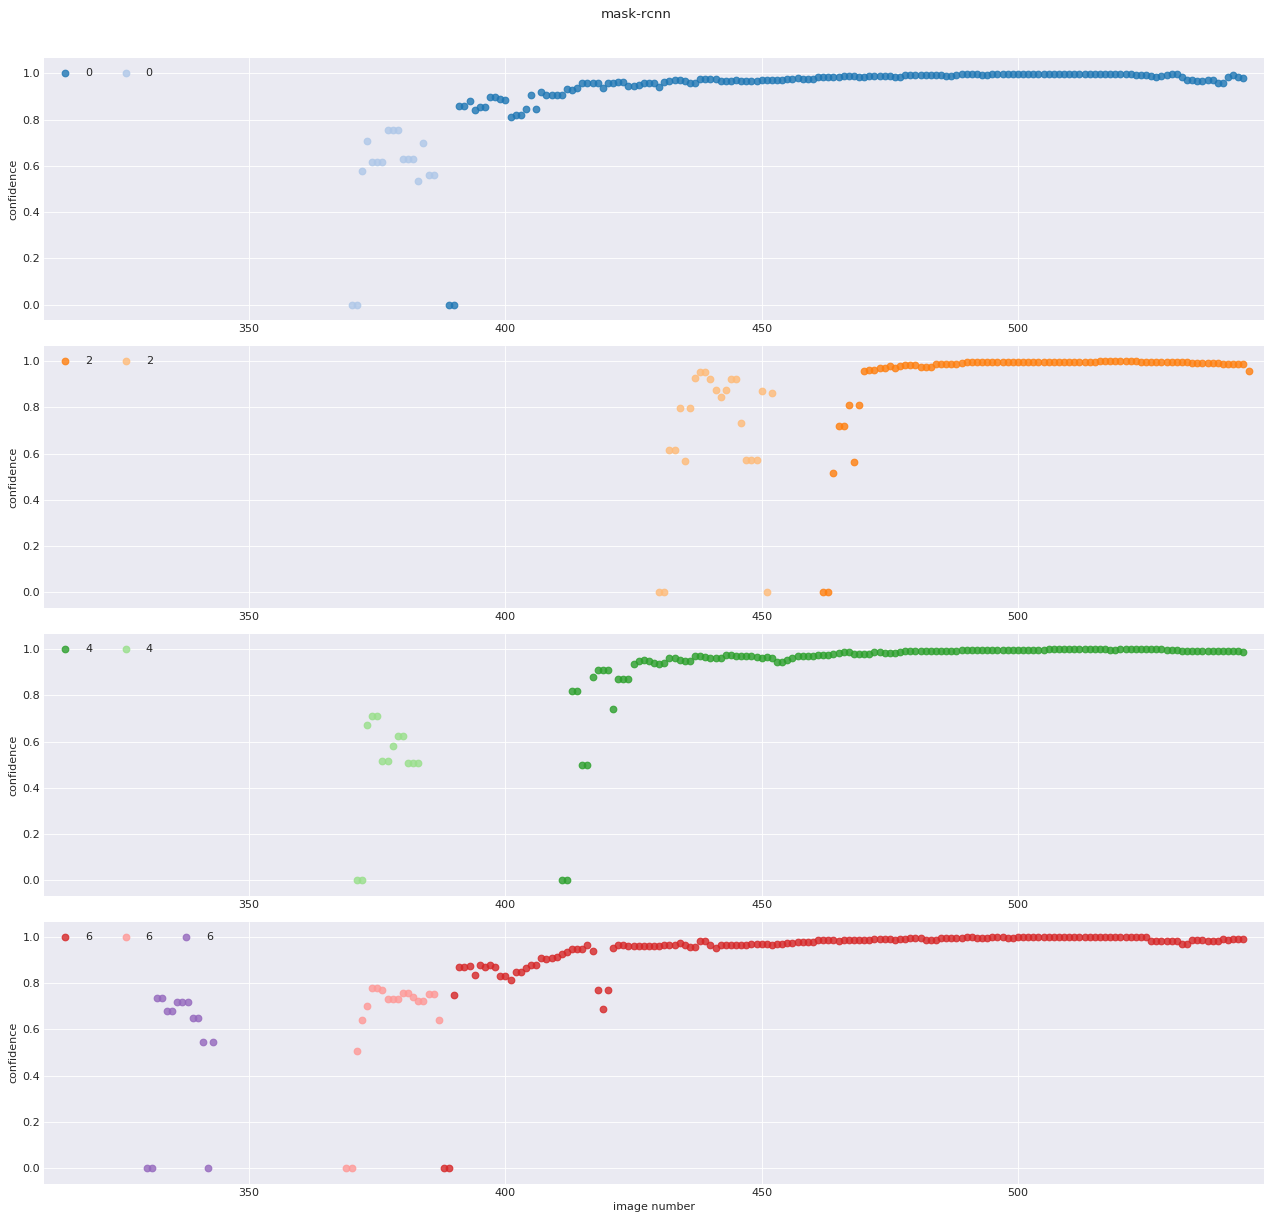

In [33]:
plt.style.use('seaborn-darkgrid')
####-----------confidence---------------

fig_num=1
fig = plt.figure(figsize=(16,16), dpi= 80)

for i in channel_list:
    y = confidence_mat[i][start_frame:]
    y1= signal.medfilt(y,3)     
    range_list =plot_count(y1)
    
    
      
    line_count = 0
    for r in range_list:
    
    #global_y=y1
    #X = range(r[0]+start_frame,r[1]+start_frame+1)
        Y=np.zeros(image_num-start_frame)
        
        Y=y1[r[0]:r[1]+1]
        X=range(r[0]+start_frame,r[1]+1+start_frame)
        
        plt.subplot(np.size(channel_list),1,fig_num)
        plt.scatter(X,Y,alpha=0.8,label=i,color=tableau20[i+line_count])
        line_count=line_count+1
        
    fig_num=fig_num+1
    plt.legend(loc='upper left', ncol=3)
    plt.ylabel('confidence')
    plt.xlim(start_frame, image_num)  
plt.xlabel('image number')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle(method, fontsize=12)
    



### 過濾(method2)

Text(0.5,0.98,'mask-rcnn')

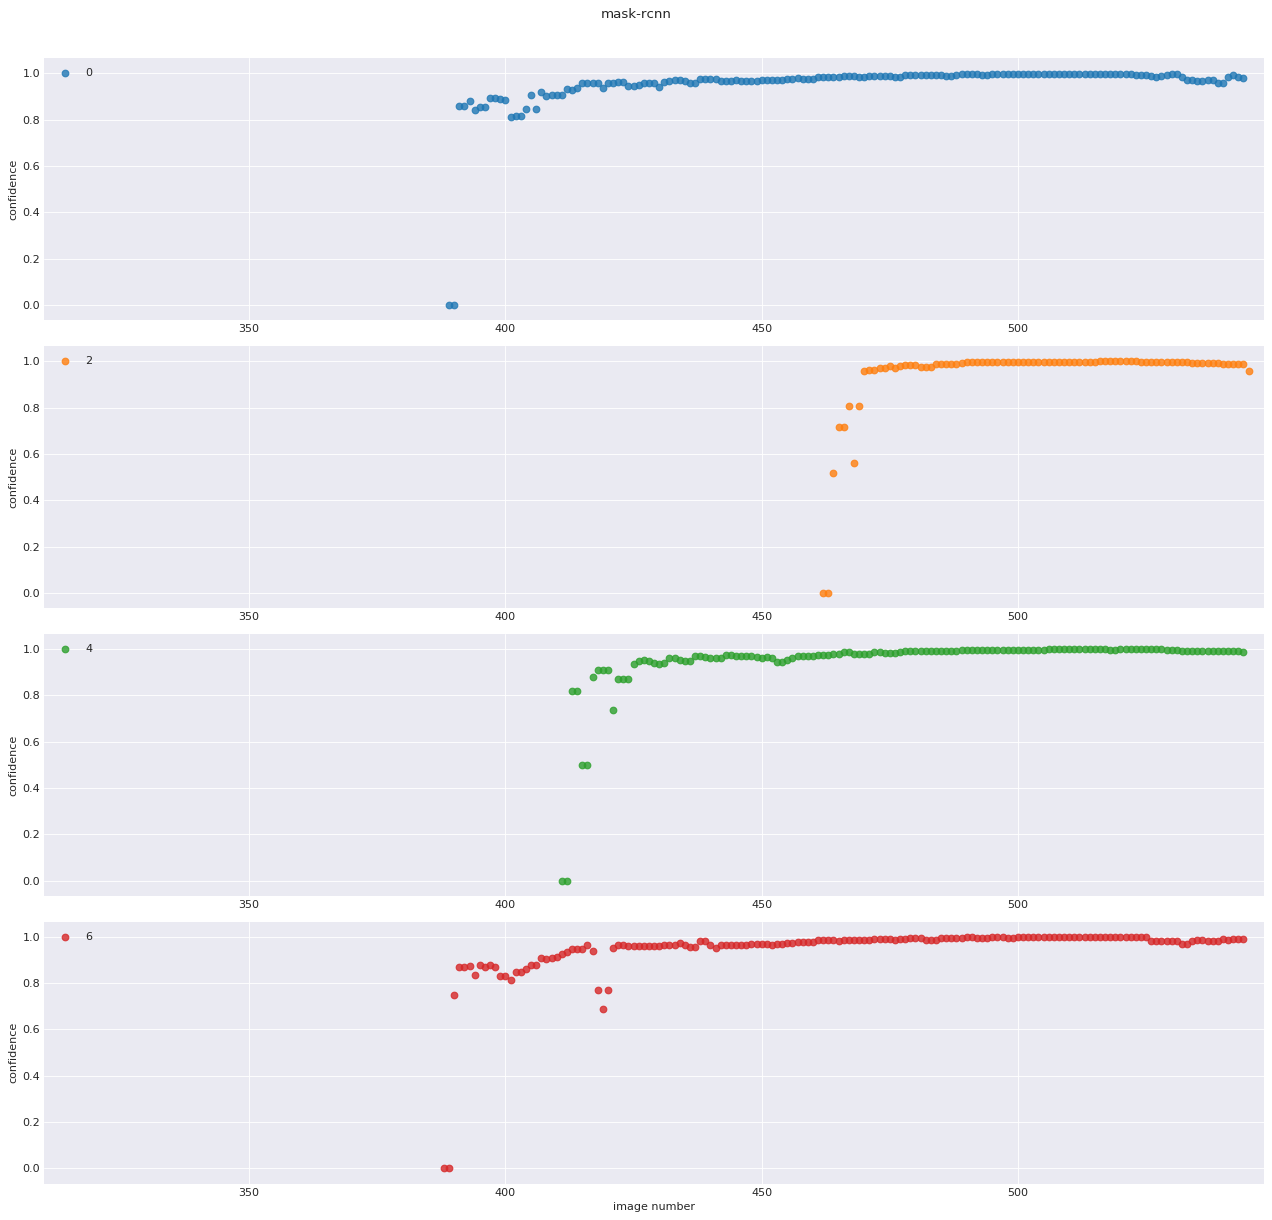

In [35]:
plt.style.use('seaborn-darkgrid')
####-----------confidence---------------

fig_num=1
fig = plt.figure(figsize=(16,16), dpi= 80)

for i in channel_list:
    y = confidence_mat[i][start_frame:]
    y1= signal.medfilt(y,3)     
    range_list =plot_count(y1)
    
      
    line_count = 0
    r= range_list[0]
    
    #global_y=y1
    #X = range(r[0]+start_frame,r[1]+start_frame+1)
    Y=np.zeros(image_num-start_frame)
        
    Y=y1[r[0]:r[1]+1]
    X=range(r[0]+start_frame,r[1]+1+start_frame)
    plt.subplot(np.size(channel_list),1,fig_num)
    plt.scatter(X,Y,alpha=0.8,label=i,color=tableau20[i+line_count])
    line_count=line_count+1
        
    fig_num=fig_num+1
    plt.legend(loc='upper left', ncol=3)
    plt.ylabel('confidence')
    plt.xlim(start_frame, image_num)  
plt.xlabel('image number')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle(method, fontsize=12)

### 沒過濾  (Method2)

Text(0.5,1,'mask-rcnn')

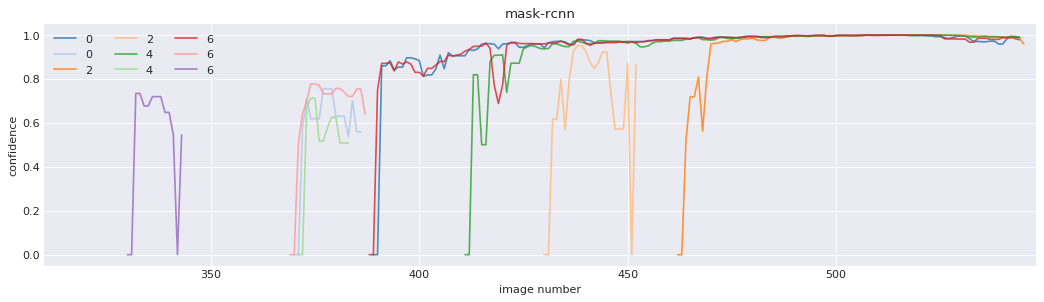

In [36]:
plt.style.use('seaborn-darkgrid')
####-----------confidence---------------

fig_num=1
plt.figure(figsize=(16,4), dpi= 80)
for i in channel_list:
    y = confidence_mat[i][start_frame:]
    y1= signal.medfilt(y,3)     
    range_list =plot_count(y1)
    plt.xlim(start_frame, image_num)
    line_count = 0
    for r in range_list:
    #global_y=y1
        X = range(r[0]+start_frame,r[1]+start_frame+1)
        Y=np.zeros(image_num-start_frame)
        Y[r[0]:r[1]+1]=y1[r[0]:r[1]+1]
    #plt.subplot(4,1,fig_num)
        plt.plot(X,y1[r[0]:r[1]+1],alpha=0.8,label=i,color=tableau20[i+line_count])
        line_count=line_count+1
    fig_num=fig_num+1 
plt.legend(loc='upper left', ncol=3)
plt.xlabel('image number')
plt.ylabel('confidence')
plt.title(method)

### 過濾 

Text(0.5,1,'mask-rcnn')

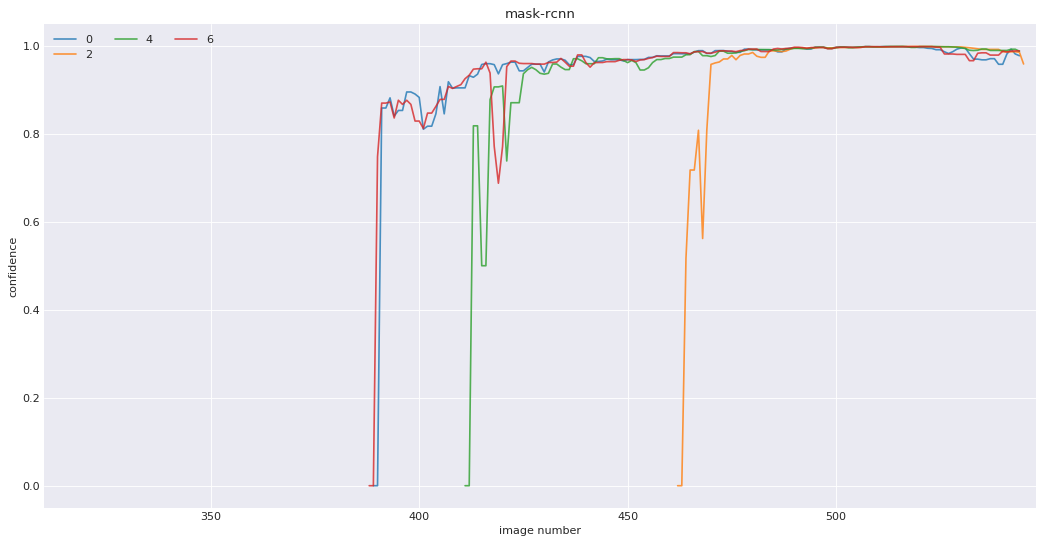

In [37]:
plt.style.use('seaborn-darkgrid')
####-----------confidence---------------

fig_num=1
plt.figure(figsize=(16,8), dpi= 80)
for i in channel_list:
    y = confidence_mat[i][start_frame:]
    y1= signal.medfilt(y,3)     
    range_list =plot_count(y1)
    plt.xlim(start_frame, image_num)
    line_count = 0
    r= range_list[0]
    
    X = range(r[0]+start_frame,r[1]+start_frame+1)
    Y=np.zeros(image_num-start_frame)
    Y[r[0]:r[1]+1]=y1[r[0]:r[1]+1]
    
    plt.plot(X,y1[r[0]:r[1]+1],alpha=0.8,label=i,color=tableau20[i+line_count])
    line_count=line_count+1
    fig_num=fig_num+1 
plt.legend(loc='upper left', ncol=3)
plt.xlabel('image number')
plt.ylabel('confidence')
plt.title(method)

## area 

Text(0.5,1,'mask-rcnn  area')

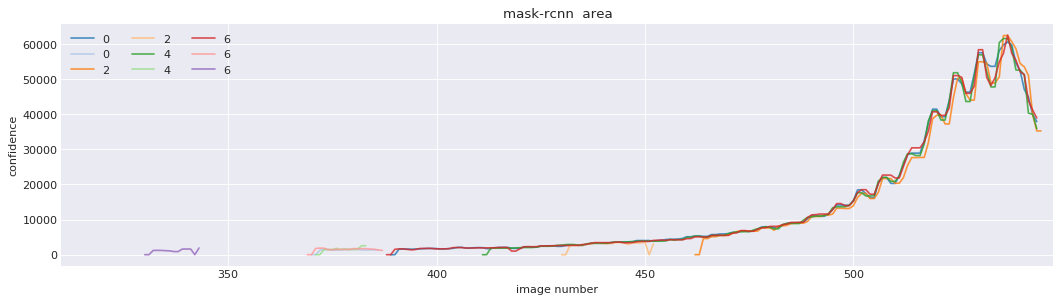

In [194]:
plt.style.use('seaborn-darkgrid')
####-----------confidence---------------

fig_num=1
plt.figure(figsize=(16,4), dpi= 80)
for i in channel_list:
    y = area_mat[i][start_frame:]
    y1= signal.medfilt(y,3)     
    range_list =plot_count(y1)
    plt.xlim(start_frame, image_num)
    line_count = 0
    for r in range_list:
    #global_y=y1
        X = range(r[0]+start_frame,r[1]+start_frame+1)
        Y=np.zeros(image_num-start_frame)
        Y[r[0]:r[1]+1]=y1[r[0]:r[1]+1]
    #plt.subplot(4,1,fig_num)
        plt.plot(X,y1[r[0]:r[1]+1],alpha=0.8,label=i,color=tableau20[i+line_count])
        line_count=line_count+1
    fig_num=fig_num+1 
plt.legend(loc='upper left', ncol=3)
plt.xlabel('image number')
plt.ylabel('confidence')
plt.title(method+'  area')

-0.14285714285714285
-0.1192084942084942
-0.1009603451896825
-0.1089349376114082
-0.12135593220338983
[(412, 1728.0), (418, 1825.0), (541, 47089.0), (543, 39991.0), (375, 1296.0)]
-0.10417238790941213
-0.21679197994987467
-0.1185
-0.12552552552552554
-1.0
[(533, 48931.0), (543, 40000.0), (544, 35260.0), (446, 2912.0), (451, 0.0)]
-0.10816777041942605
-0.10584115327077383
-0.2129611555729065
-0.1024
-0.19900497512437812
[(527, 43632.0), (539, 52598.0), (542, 40320.0), (544, 35904.0), (377, 1449.0)]
-0.4965753424657534
-0.1361269993492482
-0.14509651004094365
-0.2322198275862069
-0.13846153846153847
-0.18333333333333332
-1.0
[(418, 1029.0), (532, 50445.0), (542, 43848.0), (374, 1425.0), (386, 1344.0), (337, 882.0), (342, 0.0)]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


Text(0.5,0.98,'mask-rcnn')

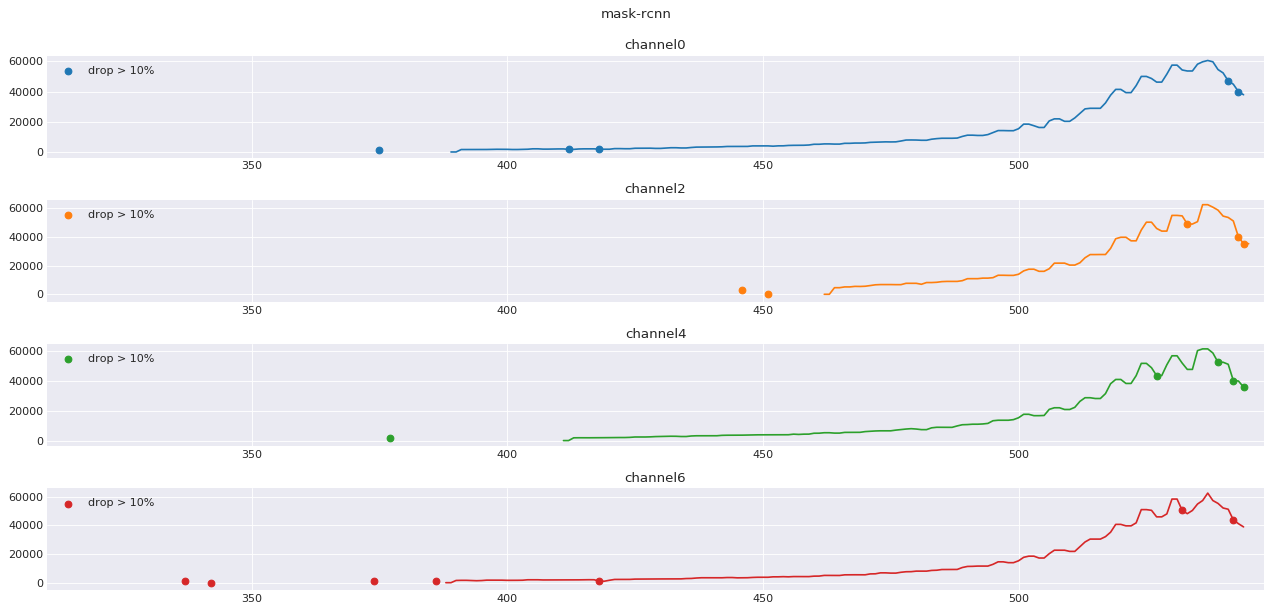

In [195]:
fig = plt.figure(figsize=(16,8), dpi= 80)                
for idx,ch in enumerate(channel_list):            
       
    y = area_mat[ch][start_frame:]           
    y1= signal.medfilt(y,3)      
    range_list =plot_count(y1)   # (1) cout_range   (2) plot_count
    #print(ch)
    drop_list = filter_drop(y1,range_list,0.1)    

    x=range(range_list[0][0]+start_frame,range_list[0][1]+1+start_frame)
    Y=y1[range_list[0][0]:range_list[0][1]+1]
    plt.subplot(np.size(channel_list),1,idx+1)
    plt.plot(x,Y,color=tableau20[ch])
    print(drop_list)
    #print(zip(*drop_list))
    if drop_list:
        plt.scatter(*zip(*drop_list),color=tableau20[ch],label="drop > 10%")
    plt.title("channel"+str(ch))
    plt.legend(loc='upper left')    

    plt.xlim(start_frame,image_num)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle(method, fontsize=12)

Text(0.5,1,'mask-rcnn')

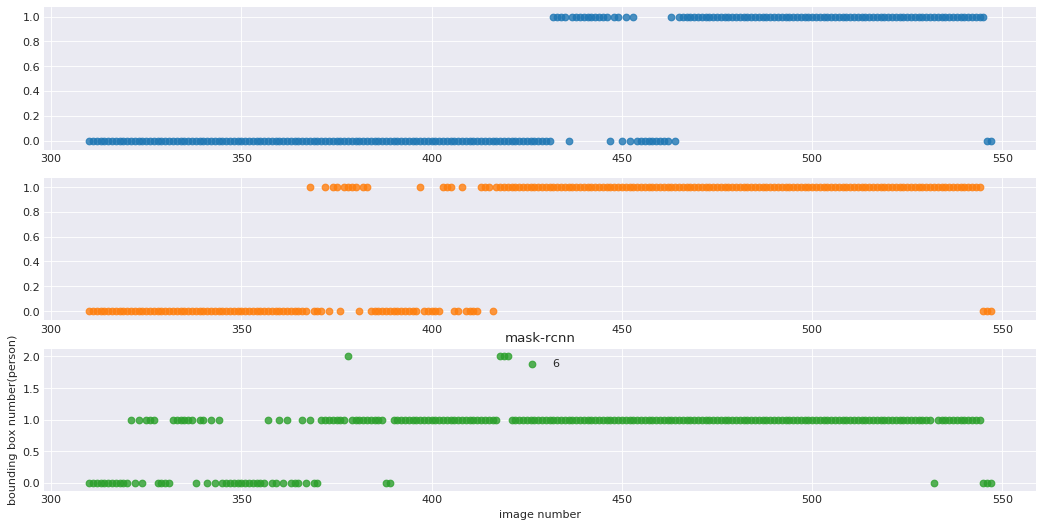

In [26]:
global_y=[]
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(16,8), dpi= 80)                
####-----------bbox number---------------

for idx,channel in enumerate(channel_list):
    plt.subplot(np.size(channel_list),1,idx+1)
    x=range(start_frame,image_num)
    y = ppl_count[channel][start_frame:]
    plt.scatter(x, y, alpha=0.8, label=channel , color=tableau20[idx*2])
plt.legend(loc='upper center', ncol=3)
plt.xlabel('image number')
plt.ylabel('bounding box number(person)')
plt.title(method)

In [159]:
X = range(420,520)
Y=global_y[420:520]
print(global_y)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.9028854  0.9028854
 0.9028854  0.9554458  0.9554458  0.9825905  0.8459848  0.9807993
 0.8697855  0.94412845 0.9035437  0.94412845 0.9035437  0.
 0.         0.         0.         0.69725734 0.69725734 0.5419758
 0.         0.5419758  0.86668396 0.98351514 0.86668396 0.
 0.         0.         0.7776371  0.7776371  0.         0.
 0.         0.56846696 0.56846696 0

## 與tracking結果比較